In [1]:
#!/usr/bin/env python
# coding: utf-8
%matplotlib inline
%reload_ext autoreload
%autoreload 
from IPython.display import HTML, display
import sys
import numpy as np
sys.path.insert(0, '../')
from flightgoggles.env import *
def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0: 
        return v
    else:
        return v / norm
# -- CONSTANT VARS ---
radius = 8
start_pose = np.array([0, -15., -2., np.pi / 2])

target_pose = np.zeros(4)
target_pose[:3] = start_pose[:3] + np.array([9.0,-9.0,0.0])
target_pose[3] = start_pose[3] + np.pi/2

num_waypoints = 5
radius = 10

EPSILON = 1.
#2 * np.pi  * radius * 0.2
#2 * np.pi * radius / num_waypoints * 6 # how decide this??
LOOPS = 1


AMBITION = 2.

DEFAULT_THRUST = 8.

# -- END CONSTANT VARS -- 

waypoint_coords = np.vstack((np.linspace(start_pose[0], target_pose[0], num=num_waypoints),
                             np.linspace(start_pose[1], target_pose[1], num=num_waypoints),
                             np.linspace(start_pose[2], target_pose[2], num=num_waypoints),
                             np.linspace(start_pose[3], target_pose[3], num=num_waypoints)))
if __name__ == "__main__":
    
    # drone flips over when going too fast ? ? ? SimSpeed adjustment needed??
    env = flightgoggles_env(
        cfg_dir="../config",
        cfg_fgclient="FlightGogglesClient_testing.yaml",
        cfg_uav="multicopterDynamicsSimSpeed.yaml") # 30 max_speed/accel multicopterDynamicsSimSpeed
    env.set_state_vehicle(vehicle_id="uav1", 
                          position = start_pose[:3],
                          attitude_euler_angle=np.array([0., 0., 0.]))
    curr_pos = env.get_state("uav1")["position"]
    curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
    curr_vel = env.get_state("uav1")["velocity"]

    fol_accumulator = None
    pos_accumulator = np.array([curr_pos])
    per_accumulator = None
    
    rand_accumulator = None
    
    curr_waypoint = waypoint_coords.T[0]
    
    time_counter = 0
    crash = False
    for waypoint in waypoint_coords.T:
        prev_waypoint = curr_waypoint
        curr_waypoint = waypoint
        
        if (np.array_equal(curr_waypoint, waypoint_coords.T[-1])):
            EPSILON = 0.01
        
        while np.linalg.norm(curr_pos - curr_waypoint[:3]) >= EPSILON:
            time_counter += 0.01
            curr_pos = env.get_state("uav1")["position"]
            curr_att = env.get_state("uav1")["attitude_euler_angle"][2]
            curr_vel = env.get_state("uav1")["velocity"]
            
            # clean solution from: https://stackoverflow.com/questions/10301001/perpendicular-on-a-line-segment-from-a-given-point
            dx = curr_waypoint[0] - prev_waypoint[0]
            dy = curr_waypoint[1] - prev_waypoint[1]
            u = ((curr_pos[0] - prev_waypoint[0]) * dx + (curr_pos[1] - prev_waypoint[1]) * dy) / (dx*dy + dx*dy);

            # 2d only for now
            curr_pos_perpend = np.array([prev_waypoint[0] + u * dx,
                                         prev_waypoint[1] + u * dy, curr_pos[2]])
            
            if (np.array_equal(curr_waypoint, waypoint_coords.T[-1]) or 
                np.array_equal(curr_waypoint, waypoint_coords.T[1])):
                target_pose = curr_waypoint
                collided = env.proceed_waypoint(vehicle_id="uav1",
                                                waypoint_command=target_pose,
                                                duration=0.01)
            else:
                target_pose = (curr_pos_perpend + 
                               normalize(curr_waypoint[:3] - curr_pos_perpend) * AMBITION)
                
                # curr_att considers x=0 as pi/2
                att_to_target = np.arctan2(target_pose[1] - curr_pos[1],
                                           target_pose[0] - curr_pos[0])
                vel_att = np.arctan2(curr_vel[1], curr_vel[0])
                    
                
                # MISC
                rand_accumulator = np.append(rand_accumulator, (att_to_target - vel_att) * 0.1)

                curr_att -= np.pi/2                
                pos_error = np.array([target_pose[0] - curr_pos[0],
                                      target_pose[1] - curr_pos[1],
                                      target_pose[2] - curr_pos[2]])
                
                pid = np.array(7 * pos_error - 3 * curr_vel)
                pid[2] -= 9.81
                collided = env.proceed_angular_rate(vehicle_id="uav1",
                                                    angular_rate_command=(att_to_target - vel_att) ,
                                                    thrust_command=np.linalg.norm(pid),
                                                    duration=0.01)
    
            if per_accumulator is None:
                per_accumulator = np.array([curr_pos_perpend])
            else:
                per_accumulator = np.vstack((per_accumulator, curr_pos_perpend))
    
            pos_accumulator = np.vstack((pos_accumulator, curr_pos))
            if collided:
                crash = True
                break
        if crash:
            print("CRASHED! :(")
            break
    
    with np.printoptions(precision=2, suppress=True):
        print("Final pose", np.append(env.get_state("uav1")["position"],
                                      env.get_state("uav1")["attitude_euler_angle"][2]))
        
    ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=300)
    if "cam1" in ani_set.keys():
        display(HTML(ani_set["cam1"].to_html5_video()))
    env.close()












CRASHED! :(
Final pose [ 7.42 -8.22 -3.95 -1.04]


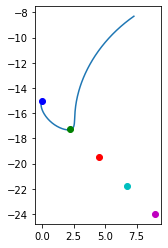

In [2]:
# Orange dots are the waypoints, dotted are waypoints
# coloration suggests the order
import itertools
import matplotlib.pyplot as plt

colors = itertools.cycle(['b', 'g', 'r', 'c', 'm', 'y', 'k'])

plt.gca().set_aspect('equal', adjustable='box')
plt.plot(pos_accumulator.T[0], pos_accumulator.T[1])
for column in waypoint_coords.T:
    plt.plot(column[0], column[1], 'o' + next(colors))

In [ ]:
# # SEE HOW RATE WORKS

# #!/usr/bin/env python
# # coding: utf-8
# %matplotlib inline
# %reload_ext autoreload
# %autoreload 2
# from IPython.display import HTML, display
# import sys
# import numpy as np
# from IPython.display import HTML, display

# sys.path.insert(0, '../')
# from flightgoggles.env import *

# if __name__ == "__main__":
#     env = flightgoggles_env(
#         cfg_dir="../config",
#         cfg_fgclient="FlightGogglesClient_testing.yaml",
#         cfg_uav="multicopterDynamicsSim.yaml")

#     start_pos = np.array([0, -15., -2.])
#     env.set_state_vehicle(vehicle_id="uav1", 
#                           position = start_pos,
#                           attitude_euler_angle=np.array([0.,0.,-np.pi/2]))
    
#     att_accumulator = np.array([env.get_state("uav1")["attitude_euler_angle"][2]])
#     for _ in range(500):
#         collided = env.proceed_angular_rate(vehicle_id="uav1",
#                                             angular_rate_command=0.2,
#                                             thrust_command=9.81,
#                                             duration=0.01)
#         att_accumulator = np.append(att_accumulator, env.get_state("uav1")["attitude_euler_angle"][2])
#         if collided:
#             stop = True
#             break

    
#     env.plot_state(vehicle_id="uav1", attribute="position")
#     env.plot_state(vehicle_id="uav1", attribute="velocity")

#     ani_set = env.plot_state_video(flag_save=False, filename="uav", dpi=400)
#     if "cam1" in ani_set.keys():
#         display(HTML(ani_set["cam1"].to_html5_video()))
#     env.close()